# Trial 1


In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd

In [ ]:
from textblob import TextBlob

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CZ4034/cleanedData.csv', header = None)
train_df.head()

,0,1
0,text,sentiment
1,one reviewer mentioned watching oz episode hoo...,0
2,wonderful little production filming technique ...,0
3,thought wonderful way spend time hot summer we...,0
4,basically family little boy jake think zombie ...,1


In [ ]:
# # Removes all the <br> in the reviews
# train_df['Review'] = train_df['Review'].str.replace('<br />', '')

## Aspect Based Extraction

In [ ]:
# from gensim.summarization.textcleaner import split_sentences 
# temp = []
data_to_list = train_df['Review'].values.tolist()

# for i in range(len(data_to_list)):
#   # We want to search how many sentences there are - By finding full stops 
#     a_list = split_sentences(re.sub(r'\.(?=[^ \W\d])', '. ', data_to_list[i]))
#     for x in a_list:
#       temp.append(x)
  
# print(len(temp))


In [ ]:
# We want to put temp as a table 
df_sentences = pd.DataFrame(data_to_list, columns = ['Reviews'])
df_sentences['Aspect'] = np.nan
df_sentences

,Reviews,Aspect
0,text,NaN
1,one reviewer mentioned watching oz episode hoo...,NaN
2,wonderful little production filming technique ...,NaN
3,thought wonderful way spend time hot summer we...,NaN
4,basically family little boy jake think zombie ...,NaN
...,...,...
74997,comment may bit spoiler worth stop care enough...,NaN
74998,saucy misadventure four au pair arrive london ...,NaN
74999,oh italian assuming movie aristocrat weird fet...,NaN
75000,eight academy nomination beyond belief think b...,NaN


## Aspect Terms Categorization

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Find Actor, Music, Director using NER 

# Find Story-Line, Visuals, Action, Comedy using Rule-Based Heuristic 

# We don't care about the aspects, we just want to filter out by some heuristic 
def classify_aspect(sentences):
  ps = PorterStemmer()
  storyline = [ps.stem('story'), ps.stem('script'), ps.stem('plot'), ps.stem('storyline'), ps.stem('spoiler'), ps.stem('development'), ps.stem('series'), ps.stem('scene')]
  visuals = [ps.stem('visual'), ps.stem('graphic'), 'cgi', ps.stem('sight'), ps.stem('cinematography'), ps.stem('landscape'), ps.stem('lighting')]
  actors = [ps.stem('actor'), ps.stem('actress'), ps.stem('cast'), ps.stem('act'), ps.stem('performer')]
  music = [ps.stem('sound'), ps.stem('soundtrack'), ps.stem('music'), ps.stem('song'), ps.stem('melody'), ps.stem('tune'), ps.stem('chord')]
  aspects = []
  for sentence in sentences:
    target = []
    doc = word_tokenize(sentence)
    for token in doc:
      if ps.stem(token) in storyline:
        target.append('story')
      if ps.stem(token) in visuals:
        target.append('visuals')
      if ps.stem(token) in actors:
        target.append('actor')
      if ps.stem(token) in music:
        target.append('music')
    aspects.append({'aspect': target})
  
         
  return aspects


In [ ]:
generated_aspects = classify_aspect(data_to_list)
print(generated_aspects)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# Now we try to put the aspect to sentences
x = 0

for aspect in generated_aspects:
  if len(aspect['aspect']) > 0 :
    df_sentences.loc[x, ['Aspect']] = ', '.join(aspect['aspect'])
  else:
    df_sentences.loc[x, ['Aspect']] = np.nan
  x += 1


In [ ]:
df_sentences

,Reviews,Aspect
0,text,NaN
1,one reviewer mentioned watching oz episode hoo...,"story, story, visuals"
2,wonderful little production filming technique ...,"actor, actor, story"
3,thought wonderful way spend time hot summer we...,"visuals, story"
4,basically family little boy jake think zombie ...,NaN
...,...,...
74997,comment may bit spoiler worth stop care enough...,"story, music, music, story"
74998,saucy misadventure four au pair arrive london ...,"story, actor, story, music, story"
74999,oh italian assuming movie aristocrat weird fet...,NaN
75000,eight academy nomination beyond belief think b...,"story, actor"


In [ ]:
df_sentences['Aspect'].value_counts()

story                                                                                       6680
actor                                                                                       4676
story, story                                                                                3557
story, actor                                                                                2280
actor, story                                                                                2228
                                                                                            ... 
visuals, music, story, actor, story, actor, visuals                                            1
actor, story, actor, music, story, music, music, story, story                                  1
story, actor, visuals, actor, story, story, actor                                              1
story, visuals, story, story, music, music, visuals, story, actor, actor, visuals, story       1
actor, actor, music, actor, st

In [ ]:
df_sentences.to_csv('multiple_aspects.csv')

## Cleaning Data

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CZ4034/multiple_aspects.csv')
# train_df = df_sentences
train_df

,Unnamed: 0,Reviews,Aspect
0,0,text,NaN
1,1,one reviewer mentioned watching oz episode hoo...,"story, story, visuals"
2,2,wonderful little production filming technique ...,"actor, actor, story"
3,3,thought wonderful way spend time hot summer we...,"visuals, story"
4,4,basically family little boy jake think zombie ...,NaN
...,...,...,...
74997,74997,comment may bit spoiler worth stop care enough...,"story, music, music, story"
74998,74998,saucy misadventure four au pair arrive london ...,"story, actor, story, music, story"
74999,74999,oh italian assuming movie aristocrat weird fet...,NaN
75000,75000,eight academy nomination beyond belief think b...,"story, actor"


In [ ]:
train_df['Aspect'].value_counts().head(20)


story                                6680
actor                                4676
story, story                         3557
story, actor                         2280
actor, story                         2228
actor, actor                         1778
story, story, story                  1653
music                                1297
story, story, actor                   886
actor, story, story                   877
story, story, story, story            851
story, actor, story                   848
visuals                               785
story, actor, actor                   782
actor, actor, actor                   718
actor, actor, story                   646
story, music                          530
actor, story, actor                   445
music, story                          432
story, story, story, story, story     429
Name: Aspect, dtype: int64

In [ ]:
# Clean up some vlues on the file 
# Remaining data not categorized 
train_df.loc[(train_df['Aspect'] == 'story, story')] = 'story'
train_df.loc[(train_df['Aspect'] == 'story, story, story')] = 'story'
train_df.loc[(train_df['Aspect'] == 'story, story, story, story')] = 'story'
train_df.loc[(train_df['Aspect'] == 'story, story, story, story, story')] = 'story'
train_df.loc[(train_df['Aspect'] == 'story, story, story, story, story, story')] = 'story'
train_df.loc[(train_df['Aspect'] == 'story, story, story, story, story, story, story')] = 'story'
train_df.loc[(train_df['Aspect'] == 'story, story, story, story, story, story, story, story')] = 'story'
train_df.loc[(train_df['Aspect'] == 'story, story, story, story, story, story, story, story, story')] = 'story'

train_df.loc[(train_df['Aspect'] == 'actor, actor')] = 'actor'
train_df.loc[(train_df['Aspect'] == 'actor, actor, actor')] = 'actor'
train_df.loc[(train_df['Aspect'] == 'actor, actor, actor, actor')] = 'actor'
train_df.loc[(train_df['Aspect'] == 'actor, actor, actor, actor, actor')] = 'actor'
train_df.loc[(train_df['Aspect'] == 'actor, actor, actor, actor, actor, actor')] = 'actor'
train_df.loc[(train_df['Aspect'] == 'actor, actor, actor, actor, actor, actor, actor')] = 'actor'
train_df.loc[(train_df['Aspect'] == 'actor, actor, actor, actor, actor, actor, actor, actor')] = 'actor'
train_df.loc[(train_df['Aspect'] == 'actor, actor, actor, actor, actor, actor, actor, actor, actor')] = 'actor'

train_df.loc[(train_df['Aspect'] == 'visuals, visuals')] = 'visuals'
train_df.loc[(train_df['Aspect'] == 'visuals, visuals, visuals')] = 'visuals'
train_df.loc[(train_df['Aspect'] == 'visuals, visuals, visuals, visuals')] = 'visuals'
train_df.loc[(train_df['Aspect'] == 'visuals, visuals, visuals, visuals, visuals')] = 'visuals'
train_df.loc[(train_df['Aspect'] == 'visuals, visuals, visuals, visuals, visuals, visuals')] = 'visuals'
train_df.loc[(train_df['Aspect'] == 'visuals, visuals, visuals, visuals, visuals, visuals, visuals')] = 'visuals'
train_df.loc[(train_df['Aspect'] == 'visuals, visuals, visuals, visuals, visuals, visuals, visuals, visuals')] = 'visuals'
train_df.loc[(train_df['Aspect'] == 'visuals, visuals, visuals, visuals, visuals, visuals, visuals, visuals, visuals')] = 'visuals'

train_df.loc[(train_df['Aspect'] == 'music, music')] = 'music'
train_df.loc[(train_df['Aspect'] == 'music, music, music')] = 'music'
train_df.loc[(train_df['Aspect'] == 'music, music, music, music')] = 'music'
train_df.loc[(train_df['Aspect'] == 'music, music, music, music, music')] = 'music'
train_df.loc[(train_df['Aspect'] == 'music, music, music, music, music, music')] = 'music'
train_df.loc[(train_df['Aspect'] == 'music, music, music, music, music, music, music')] = 'music'
train_df.loc[(train_df['Aspect'] == 'music, music, music, music, music, music, music, music')] = 'music'
train_df.loc[(train_df['Aspect'] == 'music, music, music, music, music, music, music, music, music')] = 'music'

# train_df.loc[(train_df['Aspect'] == 'visuals, actor')] = 'visuals'
# train_df.loc[(train_df['Aspect'] == 'actor, visuals')] = 'visuals'


In [ ]:
train_df['Aspect'].value_counts().head(20)

story                         13545
actor                          7694
story, actor                   2280
actor, story                   2228
music                          1987
visuals                         886
story, story, actor             886
actor, story, story             877
story, actor, story             848
story, actor, actor             782
actor, actor, story             646
story, music                    530
actor, story, actor             445
music, story                    432
story, visuals                  383
actor, music                    346
music, actor                    345
story, story, story, actor      340
visuals, story                  316
story, actor, story, story      312
Name: Aspect, dtype: int64

In [ ]:
train_df['Aspect'] = train_df['Aspect'].replace([np.nan], 'others')
# We only take like story actor music visuals 

In [ ]:
#df_remaining = train_df.loc[train_df['Aspect'] == 'story' train_df['Aspect'] == 'actor' || train_df['Aspect'] == 'visuals', train_df['Aspect'] == 'music', train_df['Aspect'] == 'character']
# df_remaining = np.where((train_df['Aspect'] == 'story') | (train_df['Aspect'] == 'actor') | (train_df['Aspect'] == 'visuals') | (train_df['Aspect'] == 'music')| (train_df['Aspect' == 'character']))
train_df = train_df[train_df['Aspect'] != 'actor, story']
train_df = train_df[train_df['Aspect'] != 'story, actor']
train_df = train_df[train_df['Aspect'] != 'visuals, story']
train_df = train_df[train_df['Aspect'] != 'story, actor, actor']
train_df = train_df[train_df['Aspect'] != 'actor, actor, story']
train_df = train_df[train_df['Aspect'] != 'story, story, actor']
train_df = train_df[train_df['Aspect'] != 'actor, story, story']
train_df = train_df[train_df['Aspect'] != 'story, actor, story']
train_df = train_df[train_df['Aspect'] != 'visuals, actor']
train_df = train_df[train_df['Aspect'] != 'actor, visuals']
train_df = train_df[train_df['Aspect'] != 'actor, story, actor']
train_df = train_df[train_df['Aspect'] != 'visuals, story, story']
train_df = train_df[train_df['Aspect'] != 'story, visuals, story']
train_df = train_df[train_df['Aspect'] != 'visuals, actor, story']
#More

In [ ]:
train_df = train_df[train_df['Aspect'] != 'story, visuals']
train_df = train_df[train_df['Aspect'] != 'actor, actor, visuals']
train_df = train_df[train_df['Aspect'] != 'story, actor, actor, story']
train_df = train_df[train_df['Aspect'] != 'story, story, visuals']
train_df = train_df[train_df['Aspect'] != 'story, actor, actor, actor']
train_df = train_df[train_df['Aspect'] != 'visuals, story, visuals']
train_df = train_df[train_df['Aspect'] != 'visuals, visuals, story']
train_df = train_df[train_df['Aspect'] != 'actor, actor, actor, story']
train_df = train_df[train_df['Aspect'] != 'actor, story, visuals']
train_df = train_df[train_df['Aspect'] != 'visuals, visuals, visuals']
train_df = train_df[train_df['Aspect'] != 'story, story, story, story, story, story']
train_df = train_df[train_df['Aspect'] != 'story, story, story, actor']
train_df = train_df[train_df['Aspect'] != 'actor, story, story, story']
train_df = train_df[train_df['Aspect'] != 'actor, visuals, actor']
train_df = train_df[train_df['Aspect'] != 'actor, actor, story, story']
train_df = train_df[train_df['Aspect'] != 'actor, story, story, story']

In [ ]:
train_df = train_df[train_df['Aspect'] != 'story, story, story, story, story']
train_df = train_df[train_df['Aspect'] != 'actor, actor, story, actor']
train_df = train_df[train_df['Aspect'] != 'story, visuals, visuals']
train_df = train_df[train_df['Aspect'] != 'story, visuals, actor']
train_df = train_df[train_df['Aspect'] != 'actor, visuals, story']
train_df = train_df[train_df['Aspect'] != 'story, story, actor, story, story']
train_df = train_df[train_df['Aspect'] != 'visuals, story, actor']
train_df = train_df[train_df['Aspect'] != 'actor, actor, actor, actor, actor']
train_df = train_df[train_df['Aspect'] != 'story, actor, visuals']
train_df = train_df[train_df['Aspect'] != 'visuals, actor, actor']
train_df = train_df[train_df['Aspect'] != 'story, story, actor, actor']
train_df = train_df[train_df['Aspect'] != 'story, story, story, story, story, story, story, story, story, story, story, story, story']
train_df = train_df[train_df['Aspect'] != 'actor, actor, story, actor, actor, actor']
train_df = train_df[train_df['Aspect'] != 'story, story, actor, actor, story, story']
train_df = train_df[train_df['Aspect'] != 'actor, actor, actor, actor, actor, actor']
train_df = train_df[train_df['Aspect'] != 'story, actor, story, actor']
train_df = train_df[train_df['Aspect'] != 'story, actor, story, story']
train_df = train_df[train_df['Aspect'] != 'actor, story, actor, actor']
train_df = train_df[train_df['Aspect'] != 'actor, actor, actor, actor, actor, actor, story']
train_df = train_df[train_df['Aspect'] != 'visuals, actor, actor, story, story']
train_df = train_df[train_df['Aspect'] != 'story, story, visuals, visuals']
train_df = train_df[train_df['Aspect'] != 'story, story, visuals, actor']
train_df = train_df[train_df['Aspect'] != 'actor, story, actor, story, story, story']
train_df = train_df[train_df['Aspect'] != 'actor, story, story, visuals']
train_df = train_df[train_df['Aspect'] != 'actor, story, visuals, story']
train_df = train_df[train_df['Aspect'] != 'story, story, actor, story, actor, actor']
train_df = train_df[train_df['Aspect'] != 'actor, story, actor, actor, actor']
train_df = train_df[train_df['Aspect'] != 'actor, actor, story, visuals']
train_df = train_df[train_df['Aspect'] != 'visuals, actor, visuals']
train_df = train_df[train_df['Aspect'] != 'actor, visuals, story, actor, story']
train_df = train_df[train_df['Aspect'] != 'story, actor, actor, actor, actor']
train_df = train_df[train_df['Aspect'] != 'story, story, actor, story']
train_df = train_df[train_df['Aspect'] != 'actor, story, actor, story']

In [ ]:
train_df['Aspect'].value_counts().head(100)

story                                13545
others                               10921
actor                                 7694
story, actor                          2280
actor, story                          2228
                                     ...  
story, actor, story, story, actor       53
actor, story, story, actor, story       52
story, actor, actor, music              51
story, story, visuals, story            49
music, music, actor                     49
Name: Aspect, Length: 100, dtype: int64

In [ ]:
def remove_dup(s):
  l = s.split(', ')
  # print('List: ',l)
  n = [*set(l)]
  # print('Set: ',n)
  fin = str(n[0])
  for j in range(1,len(n)):
    fin += ', '
    fin += str(n[j])
    return fin    

In [ ]:

for i in train_df.index:
  if train_df['Aspect'][i] != 'story' and train_df['Aspect'][i] != 'actor' and train_df['Aspect'][i] != 'visuals' and train_df['Aspect'][i] != 'music' and train_df['Aspect'][i] != 'others':
    train_df['Aspect'][i] = remove_dup(train_df['Aspect'][i])

In [ ]:
train_df['Aspect'].value_counts().head(100)

story, actor      18766
story             13545
others            10921
visuals, story     9009
story, music       8852
actor              7694
music              1987
music, actor       1807
visuals             886
visuals, actor      849
visuals, music      611
Name: Aspect, dtype: int64

In [ ]:
# train_df.loc[(train_df['Aspect'] == 'story, actor')] = 'actor, story'
# train_df.loc[(train_df['Aspect'] == 'music, actor')] = 'actor, music'
train_df.loc[(train_df['Aspect'] == 'visuals, actor')] = 'actor, visuals'
train_df.loc[(train_df['Aspect'] == 'visuals, music')] = 'music, visuals'


In [ ]:
train_df['Aspect'].value_counts().head(100)

story             13545
story, actor      13191
others            10921
actor, story       9439
story, music       8845
actor              7694
actor, music       5227
story, visuals     2061
music              1987
visuals             886
actor, visuals      849
music, visuals      282
Name: Aspect, dtype: int64

In [ ]:
train_df['Aspect']

0            others
1            others
2            others
3            others
4            others
            ...    
690057    character
690058    character
690059    character
690060    character
690061    character
Name: Aspect, Length: 687317, dtype: object

In [ ]:
train_df.to_csv('aspect_cleaned.csv')

### Old

In [ ]:
train_df['Aspect'].value_counts()

others       554311
story         74110
actor         30294
character     16172
visuals        6505
music          5925
Name: Aspect, dtype: int64

In [ ]:
indexes = train_df[train_df.Aspect == 'others'].sample(frac=0.85).index
train_df = train_df.drop(indexes)
train_df['Aspect'].value_counts()

others       83147
story        74110
actor        30294
character    16172
visuals       6505
music         5925
Name: Aspect, dtype: int64

In [ ]:
indexes = train_df[train_df.Aspect == 'others'].sample(frac=0.7).index
train_df = train_df.drop(indexes)
indexes = train_df[train_df.Aspect == 'story'].sample(frac=0.6).index
train_df = train_df.drop(indexes)
train_df['Aspect'].value_counts()

actor        30294
story        29644
others       24944
character    16172
visuals       6505
music         5925
Name: Aspect, dtype: int64

In [ ]:
train_df.to_csv('aspect_cleaned_dropped.csv')

###New

In [ ]:
train_df

,Unnamed: 0,Reviews,Aspect
0,0,text,others
1,1,one reviewer mentioned watching oz episode hoo...,"story, visuals"
2,2,wonderful little production filming technique ...,"actor, story"
3,3,thought wonderful way spend time hot summer we...,"story, visuals"
4,4,basically family little boy jake think zombie ...,others
...,...,...,...
74997,74997,comment may bit spoiler worth stop care enough...,"story, music"
74998,74998,saucy misadventure four au pair arrive london ...,"story, music"
74999,74999,oh italian assuming movie aristocrat weird fet...,others
75000,75000,eight academy nomination beyond belief think b...,"story, actor"


In [ ]:
print(train_df['Reviews'][216])

movie without doubt perfect people rating film low grade good plot anything like thats ridiculous saying jackie chan movie bad plot like saying porn movie bad plot watch jackie chan fight scene action not much concentrated good story anything like look make movie compare american film era even later realize jackie chan movie top fight scene not really good plot american movie good plot shitty action scene compared jackie chan time porn watched porn jackie chan watched action think people rating bad plot think thats smart movie critic would rate good movie way see good movie movie keep entertained sure middle movie boring boring put way rest action scene stunt much pay change way american action movie created even stollen scene movie want true man true entertainer watch movie many jackie chan he pure everyway literally make american movie look like walk park even today movie american movie rely much special effect safety wire stunt double much police story many jackie chan film piece wo

In [ ]:
for x in range(len(train_df)):

  sentiment_scores = {}

  a = train_df['Aspect'][x]
  if not a:
    train_df.loc[x, ['Score']] = None
    continue
  aspects = a.split(', ')

  for aspect in aspects:
      if aspect == 'others':
        continue
      blob = TextBlob(aspect)
      polarity = blob.sentiment.polarity
      if polarity > 0:
          sentiment_scores[aspect] = 'positive'
      elif polarity < 0:
          sentiment_scores[aspect] = 'negative'
      else:
          sentiment_scores[aspect] = 'neutral'

  train_df.loc[x, ['Score']] = sentiment_scores

In [ ]:
train_df

,Unnamed: 0,Reviews,Aspect,Score
0,0,text,others,NaN
1,1,one reviewer mentioned watching oz episode hoo...,"story, visuals",NaN
2,2,wonderful little production filming technique ...,"actor, story",NaN
3,3,thought wonderful way spend time hot summer we...,"story, visuals",NaN
4,4,basically family little boy jake think zombie ...,others,NaN
...,...,...,...,...
74997,74997,comment may bit spoiler worth stop care enough...,"story, music",NaN
74998,74998,saucy misadventure four au pair arrive london ...,"story, music",NaN
74999,74999,oh italian assuming movie aristocrat weird fet...,others,NaN
75000,75000,eight academy nomination beyond belief think b...,"story, actor",NaN


## Define Neural Network for Classification for Aspect



In [ ]:
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Other
import re
import json
import string
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

#Keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Bidirectional, LSTM
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from keras_preprocessing.sequence import pad_sequences

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token='OOV')
tokenizer.fit_on_texts(train_df.Reviews)
sequences = tokenizer.texts_to_sequences(train_df.Reviews)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  548    6  106]
 [   0    0    0 ... 1488  867 1141]
 [   0    0    0 ...    5  607  459]
 ...
 [   0    0    0 ...    1    3 1013]
 [   0    0    0 ...  133    2 4747]
 [   0    0    0 ...    1   56    2]]


In [ ]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder()
integer_category = label_encoder.fit_transform(train_df.Aspect)
encoded_y = tf.keras.utils.to_categorical(integer_category)

In [ ]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,encoded_y, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

85113 28371 85113 28371


In [ ]:
import pickle

# saving
with open('tokenizer_aspect_based.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
absa_model2 = Sequential()
absa_model2.add(Embedding(max_words, 80, input_length=max_len))
absa_model2.add(layers.SpatialDropout1D(0.6))
absa_model2.add(Bidirectional(LSTM(64,dropout=0.6, recurrent_dropout=0.2)))
absa_model2.add(Dense(6,activation='softmax'))
absa_model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("best_model_latest_aspect.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = absa_model2.fit(X_train, y_train, epochs=6,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Epoch 1/6
2660/2660 [==============================] - ETA: 0s - loss: 0.8040 - accuracy: 0.6998
Epoch 1: val_accuracy improved from -inf to 0.81985, saving model to best_model_latest_aspect.hdf5
2660/2660 [==============================] - 811s 302ms/step - loss: 0.8040 - accuracy: 0.6998 - val_loss: 0.5227 - val_accuracy: 0.8199
Epoch 2/6
2660/2660 [==============================] - ETA: 0s - loss: 0.4716 - accuracy: 0.8344
Epoch 2: val_accuracy improved from 0.81985 to 0.85728, saving model to best_model_latest_aspect.hdf5
2660/2660 [==============================] - 798s 300ms/step - loss: 0.4716 - accuracy: 0.8344 - val_loss: 0.3985 - val_accuracy: 0.8573
Epoch 3/6
2660/2660 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8526
Epoch 3: val_accuracy improved from 0.85728 to 0.86137, saving model to best_model_latest_aspect.hdf5
2660/2660 [==============================] - 801s 301ms/step - loss: 0.4070 - accuracy: 0.8526 - val_loss: 0.3811 - val_accuracy: 0.

In [ ]:
best_model_latest_aspect = keras.models.load_model("best_model_latest_aspect.hdf5")

In [ ]:
import joblib
best_model_latest_aspect.save('best_model_latest_aspect.h5')
# to save encoder 
import pickle
# saving
with open('tokenizer_aspect_based.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
topics = ['movie', 'story', 'acting', 'action', 'comedy']

test_reviews = [
    "This was an incredible plot written.",
    "The story was very well written",
    "The storyline for this movie was pretty good.",
    "But Henry's wife reminds him how Tom used scabs and violence to end the strike (apparently blowing up the Union's headquarters - killing many people).",
    "The show was extremely nice and the supporting cast especially Peter played a great role in helping everyone", 
    "Spoiler alert: Peter died at the end "
]

sequence = tokenizer.texts_to_sequences(test_reviews)
test = pad_sequences(sequence, maxlen=max_len)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

test_aspect_categories = label_encoder.inverse_transform(np.argmax(best_model_latest_aspect.predict(test), axis = -1))
print(test_aspect_categories)


1/1 [==============================] - 1s 779ms/step
['story' 'story' 'story' 'others' 'actor' 'story']


In [ ]:
# h5 and joblib does the job

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 40)           200000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 210,006
Trainable params: 210,006
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

1689/1689 - 43s - loss: 0.3310 - accuracy: 0.8929 - 43s/epoch - 25ms/step
Restored model, accuracy: 89.29%


In [ ]:
topics = ['movie', 'story', 'acting', 'action', 'comedy']

test_reviews = [
    "This was an incredible plot written.",
    "The story was very well written",
    "The storyline for this movie was pretty good.",
    "But Henry's wife reminds him how Tom used scabs and violence to end the strike (apparently blowing up the Union's headquarters - killing many people).",
    "The show was extremely nice and the supporting cast especially Peter played a great role in helping everyone", 
    "Spoiler alert: Peter died at the end "
]

sequence = tokenizer.texts_to_sequences(test_reviews)
test = pad_sequences(sequence, maxlen=max_len)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

test_aspect_categories = label_encoder.inverse_transform(np.argmax(new_model.predict(test), axis = -1))
print(test_aspect_categories)


1/1 [==============================] - 0s 52ms/step
['story' 'story' 'story' 'others' 'actor' 'story']


## Testing with unseen data

In [ ]:
with open('tokenizer_aspect_based.pickle', 'rb') as handle:
  tokenizer = pickle.load(handle)

In [ ]:
unseen_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Latest_Clean_Test_Data.csv')
unseen_df_test = unseen_df.head(1000)

In [ ]:
unseen_df_test.head()

,Unnamed: 0,tconst,Review_Date,User ID,Rating,Review_Title,Review,Cleaned Reviews,Review_Words,Review_Date_Cleaned,Total_Syllables,Average_Syllables,flesch_reading_ease,POS tagged,Lemma,review_lemmas
0,1,tt0111161,24 May 2005,ur2074071,1,Mediocre people reward mediocre cinema.,It bugs me that this movie is rated so high- n...,It bugs me that this movie is rated so high no...,184,2005-05-24,315,1.711957,62.98,"[('bugs', 'v'), ('movie', 'n'), ('rated', 'v')...",bug movie rat high bad movie mediocre one Ap...,"['bug', 'movie', 'rated', 'high', 'bad', 'movi..."
1,2,tt0111161,24 September 2009,ur18477924,1,Terrifyingly Overrated,Shawshank is on TNT approximately five million...,Shawshank is on TNT approximately five million...,341,2009-09-24,520,1.524927,73.98,"[('Shawshank', 'n'), ('TNT', 'n'), ('approxima...",Shawshank TNT approximately five million tim...,"['shawshank', 'tnt', 'approximately', 'five', ..."
2,3,tt0111161,31 July 2005,ur1494462,1,On the world's finest films,I would humbly suggest that before praising or...,I would humbly suggest that before praising or...,179,2005-07-31,256,1.430168,81.83,"[('would', None), ('humbly', 'r'), ('suggest',...",would humbly suggest praise damn Shawshank R...,"['would', 'humbly', 'suggest', 'praising', 'da..."
3,4,tt0111161,17 July 2002,ur1800658,1,snarling critique,awful. a dreadful disgrace. the film is the mo...,awful a dreadful disgrace the film is the most...,70,2002-07-17,113,1.614286,70.63,"[('awful', 'v'), ('dreadful', 'a'), ('disgrace...",awful dreadful disgrace film cliched cinemat...,"['awful', 'dreadful', 'disgrace', 'film', 'cli..."
4,5,tt0111161,28 December 2000,ur0984259,1,A good movie but definitely not #2 of all time,"This is certainly a good movie, with universal...",This is certainly a good movie with universal ...,193,2000-12-28,294,1.523316,64.04,"[('certainly', 'r'), ('good', 'a'), ('movie', ...",certainly good movie universal theme freedom...,"['certainly', 'good', 'movie', 'universal', 't..."


In [ ]:
from gensim.summarization.textcleaner import split_sentences 
temp = []
data_to_list = unseen_df_test['Review'].values.tolist()
# print(data_to_list)

for i in range(len(data_to_list)):
  # We want to search how many sentences there are - By finding full stops 
    #a_list = nltk.tokenize.sent_tokenize(data_to_list[i])
    a_list = split_sentences(re.sub(r'\.(?=[^ \W\d])', '. ', data_to_list[i]))
    for x in a_list:
      temp.append(x)
  
print(len(temp))
# TODO - Word Boundary Spaces not there, it won't split correctly


15555


In [ ]:
from keras.models import load_model
import joblib
new_model = load_model('best_model_latest_aspect.h5')
le=joblib.load('labelEncoder.joblib')


In [ ]:
sequence = tokenizer.texts_to_sequences(temp)
test = pad_sequences(sequence, maxlen=200)
# sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

test_aspect_categories = le.inverse_transform(np.argmax(new_model.predict(test), axis = -1))
print(test_aspect_categories)


487/487 [==============================] - 36s 72ms/step
['others' 'others' 'others' ... 'others' 'story' 'others']


In [ ]:
# Run it on our model 
myDict = {}
myDict["reviews"] = temp
myDict["aspect"] = test_aspect_categories
 

In [ ]:
results = pd.DataFrame(myDict)
results

,reviews,aspect
0,It bugs me that this movie is rated so high- n...,others
1,"Apparently, mediocre people reward mediocre ci...",others
2,This movie tanked big-time when it was initial...,others
3,It wasn't until pseudo-intellectuals across th...,others
4,"In reality, ""Shawshank"" is like a sewage pump ...",character
...,...,...
15550,"Lastly, there is one important event left, abo...",character
15551,"I was very impressed with this movie, especial...",story
15552,This is a film that everyone would like and fe...,others
15553,The plot also appeals to average and ordinary ...,story


In [ ]:
results.to_csv('eval_automatic_aspect_classification.csv')

#Trial 2


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyabsa -U
from pyabsa import AspectTermExtraction as ATEPC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
config = (
    ATEPC.ATEPCConfigManager.get_atepc_config_english()
)  # this config contains 'pretrained_bert', it is based on pretrained models
config.model = ATEPC.ATEPCModelList.FAST_LCF_ATEPC  # improved version of LCF-ATEPC

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CZ4034/cleanedData.csv', header = None,  names=["Review", "Sentiment"])
train_df.head()

# Trial 3

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install spacytextblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 KB 26.5 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1


In [ ]:
# Load the spaCy model and add the TextBlob extension
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("spacytextblob")

OSError: ignored

In [ ]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import numpy as np
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

ModuleNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CZ4034/cleanedData.csv')
train_df.head()

,text,sentiment
0,one reviewer mentioned watching oz episode hoo...,0.0
1,wonderful little production filming technique ...,0.0
2,thought wonderful way spend time hot summer we...,0.0
3,basically family little boy jake think zombie ...,1.0
4,petter mattei love time money visually stunnin...,0.0


In [ ]:
train_df['sentiment'].unique()

array([ 0.,  1., nan])

In [ ]:
train_df['sentiment'] = train_df['sentiment'].replace([np.nan], 'others')
train_df = train_df[train_df['sentiment'] != 'others']

In [ ]:
train_df.groupby('sentiment').nunique()

,text
sentiment,
0.0,24894
1.0,24713


In [ ]:
# Example product reviews
reviews = ["one reviewer mentioned watching oz episode hooked right exactly happened first thing struck oz brutality unflinching scene violence set right word go trust not show faint hearted timid show pull punch regard drug sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy not high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away would say main appeal show due fact go show would not dare forget pretty picture painted mainstream audience forget charm forget romance oz not mess around first episode ever saw struck nasty surreal could not say ready watched developed taste oz got accustomed high level graphic violence not violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison experience watching oz may become comfortable uncomfortable viewing thats get touch darker side ",
           "wonderful little production filming technique unassuming old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen not got polari voice pat truly see seamless editing guided reference williams diary entry not well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional wouldream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwell mural decorating every surface terribly well done ",
           "basically family little boy jake think zombie closet parent fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller drama drama movie watchable parent divorcing arguing like real life jake closet totally ruin film expected see boogeyman similar movie instead watched drama meaningless thriller spot well playing parent descent dialog shot jake ignore ",
           "petter mattei love time money visually stunning film watch mr mattei offer u vivid portrait human relation movie seems telling u money power success people different situation encounter variation arthur schnitzler play theme director transfer action present time new york different character meet connect one connected one way another next person one seems know previous point contact stylishly film sophisticated luxurious look taken see people live world live habitat thing one get soul picture different stage loneliness one inhabits big city not exactly best place human relation find sincere fulfillment one discerns case people encounter acting good mr mattei direction steve buscemi rosario dawson carol kane michael imperioli adrian grenier rest talented cast make character come alive wish mr mattei good luck await anxiously next work "]

# Define the aspects of the product to analyze
aspects = ["story", "actor", "visuals", "music"]

# Analyze the sentiment of the product reviews for each aspect
for review in reviews:
    doc = nlp(review)
    for aspect in aspects:
        if aspect in review.lower():
            sentiment = doc._.polarity
            print(f"The sentiment of the {aspect} in this review is {sentiment}.")



ValueError: ignored

# Trial 4


In [ ]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import numpy as np
import spacy
# from spacytextblob.spacytextblob import SpacyTextBlob

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CZ4034/cleanedData.csv')
train_df.head()

,text,sentiment
0,one reviewer mentioned watching oz episode hoo...,0.0
1,wonderful little production filming technique ...,0.0
2,thought wonderful way spend time hot summer we...,0.0
3,basically family little boy jake think zombie ...,1.0
4,petter mattei love time money visually stunnin...,0.0


In [ ]:
train_df['sentiment'] = train_df['sentiment'].replace([np.nan], 'others')
train_df = train_df[train_df['sentiment'] != 'others']

In [ ]:
train_df['sentiment'] = train_df['sentiment'].astype(int)

In [ ]:
train_df

,text,sentiment
0,one reviewer mentioned watching oz episode hoo...,0
1,wonderful little production filming technique ...,0
2,thought wonderful way spend time hot summer we...,0
3,basically family little boy jake think zombie ...,1
4,petter mattei love time money visually stunnin...,0
...,...,...
74995,richard farnsworth one favorite actor usually ...,1
74996,comment may bit spoiler worth stop care enough...,1
74997,saucy misadventure four au pair arrive london ...,1
74998,oh italian assuming movie aristocrat weird fet...,1


In [ ]:
token_lens = []

for txt in train_df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [ ]:
tokens = tokenizer(train_df["text"].tolist(),
                  max_length=512,
                  truncation=True,
                  padding="max_length",
                  add_special_tokens=True, # the sequences will be encoded with the special tokens relative to their model
                  return_tensors="np")

In [ ]:
num_samples = len(train_df)

In [ ]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokens["input_ids"],tokens["attention_mask"]

(array([[  101,  1141, 12827, ...,     0,     0,     0],
        [  101,  7310,  1376, ...,     0,     0,     0],
        [  101,  1354,  7310, ...,     0,     0,     0],
        ...,
        [  101, 21718, 21977, ...,     0,     0,     0],
        [  101,  9294,  1122, ...,     0,     0,     0],
        [  101,  2022,  8717, ...,     0,     0,     0]]),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]))

In [ ]:
classes_arr = train_df["sentiment"].values
classes_arr

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
labels = np.zeros((num_samples, int(classes_arr.max())+1))
labels.shape

(75000, 2)

In [ ]:
print(labels)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [ ]:
labels[np.arange(num_samples), classes_arr] = 1
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
import tensorflow as tf

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((tokens["input_ids"],tokens["attention_mask"],labels))

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(1000,), dtype=tf.int64, name=None), TensorSpec(shape=(1000,), dtype=tf.int64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [ ]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(1000,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(1000,), dtype=tf.int64, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [ ]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 1000), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 1000), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))>

In [ ]:
split = 0.9
size = int(( tokens["input_ids"].shape[0] / batch_size) * split)
size

4218

In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [ ]:
train_ds.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 1000), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 1000), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))>

In [ ]:
from transformers import TFAutoModel

In [ ]:
bert = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_ids = tf.keras.layers.Input(shape=(1000,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(1000,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(x)

In [ ]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 1000)]       0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 1000)]       0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 1000                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=1)

4218/4218 [==============================] - 8055s 2s/step - loss: 0.6249 - accuracy: 0.6412 - val_loss: 0.5120 - val_accuracy: 0.7560


In [ ]:
model.save('/content/gdrive/MyDrive/CZ4034/Sentiment.hdf5')

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/MyDrive/CZ4034/Sentiment.hdf5')

In [ ]:
def prep_data(text):
    tokens = tokenizer(text,
                  max_length=512,
                  truncation=True,
                  padding="max_length",
                  add_special_tokens=True, # the sequences will be encoded with the special tokens relative to their model
                  return_tensors="np")
    # tokens = tokenizer.encode_plus(text, max_length=1000,
    #                                truncation=True, padding='max_length',
    #                                add_special_tokens=True, 
    #                                return_token_type_ids=False,
    #                                return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.int64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.int64)}

In [ ]:
probs = model.predict(prep_data("hello world"))
probs

InvalidArgumentError: ignored

In [ ]:
np.argmax(probs)

#BERT

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
!python --version

Python 3.9.16


In [ ]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from transformers import pipeline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CZ4034/cleanedData.csv')
train_df.head()

,text,sentiment
0,one reviewer mentioned watching oz episode hoo...,0.0
1,wonderful little production filming technique ...,0.0
2,thought wonderful way spend time hot summer we...,0.0
3,basically family little boy jake think zombie ...,1.0
4,petter mattei love time money visually stunnin...,0.0


In [ ]:
train_df['sentiment'] = train_df['sentiment'].replace([np.nan], 'others')
train_df = train_df[train_df['sentiment'] != 'others']

In [ ]:
train_df['sentiment'] = train_df['sentiment'].astype(int)

In [ ]:
inference_df = train_df.copy()

In [ ]:
smaller_df = pd.concat([
    train_df[train_df['sentiment'] == 1].sample(2000, random_state=101),
    train_df[train_df['sentiment'] == 0].sample(2000, random_state=101)
])

inference_df = smaller_df.copy()

In [ ]:
model = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
test_drive = train_df.iloc[30]
test_drive

text         taut organically gripping edward dmytryk cross...
sentiment                                                  0.0
Name: 30, dtype: object

In [ ]:
model(test_drive['text'])

[{'label': 'POSITIVE', 'score': 0.994978129863739}]

In [ ]:
inference_df['text'] = inference_df['text'].map(lambda x: x if len(x.split(' ')) <= 280 else ' '.join(x.split(' ')[:280]))

In [ ]:
y_pred = model(inference_df['text'].to_list())
y_pred_values = [0 if dictionary['label'] == 'POSITIVE' else 1 for dictionary in y_pred]
# y_pred_values

In [ ]:
y_true = inference_df['sentiment']

accuracy_score(y_true, y_pred_values)

0.798

In [ ]:
print(classification_report(y_true, y_pred_values))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      2000
           1       0.73      0.95      0.82      2000

    accuracy                           0.80      4000
   macro avg       0.83      0.80      0.79      4000
weighted avg       0.83      0.80      0.79      4000



#The rest

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook',font_scale=1.25)
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import HTML,display
import re
import timeit
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras import mixed_precision
!pip install datasets --quiet
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer,DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CZ4034/cleanedData.csv')
train_df.head()

,text,sentiment
0,one reviewer mentioned watching oz episode hoo...,0.0
1,wonderful little production filming technique ...,0.0
2,thought wonderful way spend time hot summer we...,0.0
3,basically family little boy jake think zombie ...,1.0
4,petter mattei love time money visually stunnin...,0.0


In [ ]:
train_df['sentiment'] = train_df['sentiment'].replace([np.nan], 'others')
train_df = train_df[train_df['sentiment'] != 'others']

In [ ]:
train_df['sentiment'] = train_df['sentiment'].astype(int)

In [ ]:
smaller_df = pd.concat([
    train_df[train_df['sentiment'] == 1].sample(20000, random_state=101),
    train_df[train_df['sentiment'] == 0].sample(20000, random_state=101)
])

df = smaller_df.copy()

In [ ]:
def binary_clf_evaluation(y_true,y_pred,time_taken):
    '''
    accepts true and predicted labels and calculates accuracy,precision,recall and f1_score
    '''
    model_accuracy=accuracy_score(y_true,y_pred)
    
    model_precision,model_recall,model_f1_score,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
    
    results={'accuracy':model_accuracy,
             'precision':model_precision,
             'recall':model_recall,
             'f1_score':model_f1_score,
             'time/instance':time_taken
            }
    return results

def store_results(exp_result,exp_name,overall_result=pd.DataFrame()):
    '''
    accepts the dictinary containing the various evaluation metrics for a experiment,the 
    experiment name and overall_result Dataframe and return the overall_result 
    dataframe after concatinating the results of exp_name
    '''
    df=pd.DataFrame(exp_result,index=[exp_name])
    return pd.concat([overall_result,df],axis=0)

def display_results(d):
    '''Takes a dictionary as input and display it using HTML.'''
    display(HTML(f"<h3>  <b style='color:#6495ED;font-size:22px;'>Model Performance</b>:</h3>"))
    for key,value in d.items():
        if key == "accuracy":
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:18px;'>{key}</b>:  {value*100:.2f}%</h3>"))
        elif key=='time/instance':
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:18px;'>{key}</b>:  {value:.4f} seconds</h3>"))

        else:
            display(HTML(f"<h3> <b style='color:#6495ED;font-size:18px;'>{key}</b>:  {value:.2f}</h3>"))

In [ ]:
def plot_loss_curves(history):
    
    '''
      returns seperate loss curves for training and validation metrics
    '''
    display(HTML('''<p style="background-color:#F1C40F;color:black;font-size:20px;text-align:center;border-radius:30px 60px;font-weight:bold;border:3px solid #F1C40F;">Model Performance Curves</p>"'''))
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Loss curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('loss',size=20)
    plt.legend(fontsize=15);
  # plt.show()

  # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Accuracy curves",size=20)
    plt.xlabel('epochs',size=20)
    plt.ylabel('Accuracy',size=20)
    plt.tight_layout()
    plt.legend(fontsize=15);

In [ ]:
xtrain,xtest,ytrain,ytest=train_test_split(df['text'].to_numpy(),df['sentiment'].to_numpy(),test_size=0.2,stratify=df['sentiment'].to_numpy())

In [ ]:
training_dataset=tf.data.Dataset.from_tensor_slices((xtrain,ytrain)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)
test_dataset=tf.data.Dataset.from_tensor_slices((xtest,ytest)).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [ ]:
max_vocab_length=10000

In [ ]:
# max number of words in a movie review
max([len(x.split()) for x in xtrain])

933

In [ ]:
selected_news_length=round(np.percentile(([len(x.split()) for x in xtrain]),95))
selected_news_length
# this will be able to incoorporate 95 % of the entire instances without trancating the end part.

329

## FNN

In [ ]:
textVectorizer=layers.TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=selected_news_length
);

textVectorizer.adapt(xtrain)

In [ ]:
embedding=layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    input_length=selected_news_length
)
# here each word will be represented using a 128 dim dense vector

In [ ]:
mixed_precision.set_global_policy('mixed_float16')
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
x=layers.Dropout(0.15)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_1=keras.models.Model(inputs,outputs,name="model_1")

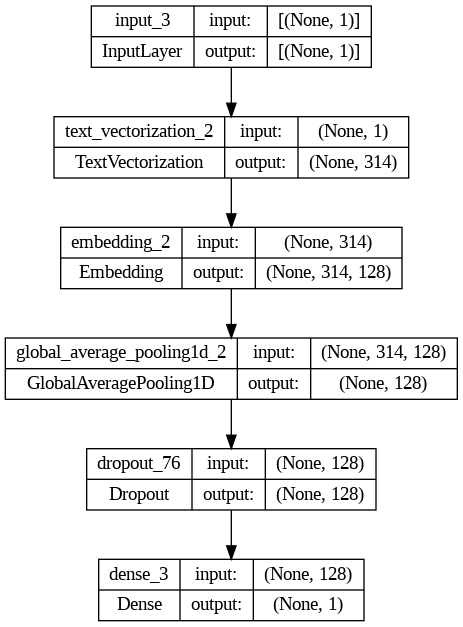

In [ ]:
# summary of model_1
keras.utils.plot_model(model_1,show_shapes=True)

In [ ]:
model_1.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
model_1_history=model_1.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
1000/1000 [==============================] - 32s 31ms/step - loss: 0.5346 - accuracy: 0.7891 - val_loss: 0.3760 - val_accuracy: 0.8723
Epoch 2/5
1000/1000 [==============================] - 28s 28ms/step - loss: 0.3078 - accuracy: 0.8913 - val_loss: 0.2945 - val_accuracy: 0.8878
Epoch 3/5
1000/1000 [==============================] - 28s 28ms/step - loss: 0.2425 - accuracy: 0.9107 - val_loss: 0.2713 - val_accuracy: 0.8945
Epoch 4/5
1000/1000 [==============================] - 28s 28ms/step - loss: 0.2074 - accuracy: 0.9251 - val_loss: 0.2650 - val_accuracy: 0.8966
Epoch 5/5
1000/1000 [==============================] - 28s 28ms/step - loss: 0.1834 - accuracy: 0.9357 - val_loss: 0.2643 - val_accuracy: 0.8978


In [ ]:
start_time=timeit.default_timer()
model_1_pred_prob=model_1.predict(test_dataset)
model_1_pred=tf.squeeze(tf.round(model_1_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_1_results=binary_clf_evaluation(ytest,model_1_pred,time_taken_per_instance)
display_results(model_1_results)

250/250 [==============================] - 2s 7ms/step


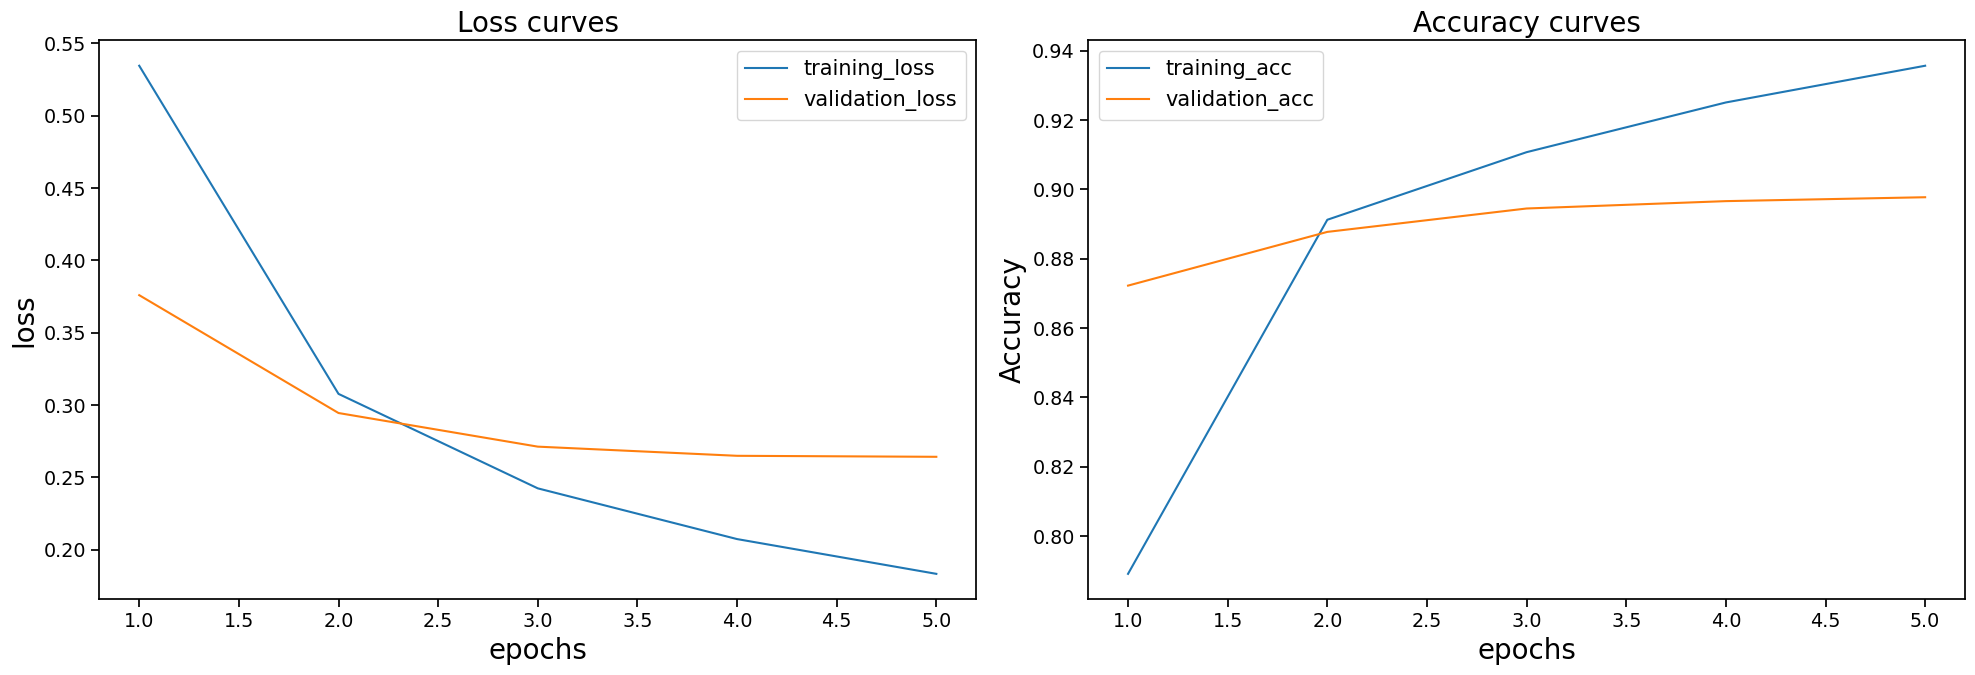

In [ ]:
plot_loss_curves(model_1_history)

In [ ]:
overall_results=store_results(model_1_results,"model_1",overall_results)
overall_results

##RNN

In [ ]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.SimpleRNN(32)(x)
x=layers.Dropout(0.2)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_2=keras.models.Model(inputs,outputs,name="model_2")

In [ ]:
# model_2 summary
keras.utils.plot_model(model_2)

In [ ]:
model_2.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
model_2_history=model_2.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

In [ ]:
start_time=timeit.default_timer()
model_2_pred_prob=model_2.predict(test_dataset)
model_2_pred=tf.squeeze(tf.round(model_2_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_2_results=binary_clf_evaluation(ytest,model_2_pred,time_taken_per_instance)
display_results(model_2_results)

##LSTM (Stacked)

In [ ]:
inputs=layers.Input(shape=(1,),dtype=tf.string)
x=textVectorizer(inputs)
x=embedding(x)
x=layers.LSTM(64,return_sequences=True)(x)
x=layers.Dropout(0.2)(x)
x=layers.LSTM(32)(x)
x=layers.Dropout(0.2)(x)
outputs=layers.Dense(1,activation='sigmoid',dtype=tf.float32)(x)
model_4=keras.models.Model(inputs,outputs,name="model_4")

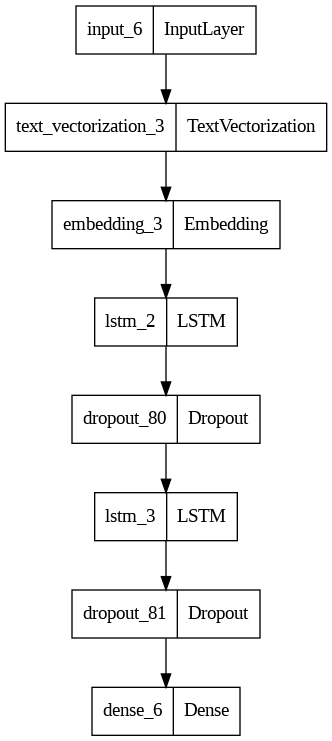

In [ ]:
keras.utils.plot_model(model_4)

In [ ]:
model_4.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
model_4_history=model_4.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
  2/100 [..............................] - ETA: 17:31 - loss: 0.6954 - accuracy: 0.4219

KeyboardInterrupt: ignored

In [ ]:
start_time=timeit.default_timer()
model_4_pred_prob=model_4.predict(test_dataset)
model_4_pred=tf.squeeze(tf.round(model_4_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_4_results=binary_clf_evaluation(ytest,model_4_pred,time_taken_per_instance)
display_results(model_4_results)

In [ ]:
plot_loss_curves(model_4_history)

##Universal Sentence Encoder(USE)

###Untuned

In [ ]:
pretained_embedding=hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable=False,input_shape=[],dtype=tf.string,name="USE")
model_5=keras.Sequential([
    pretained_embedding,
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid',dtype=tf.float32)
])

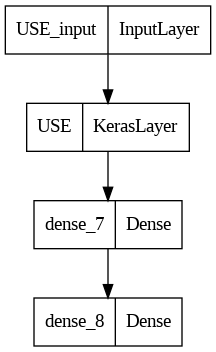

In [ ]:
keras.utils.plot_model(model_5)

In [ ]:
model_5.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
model_5_history=model_5.fit(
    training_dataset,
    steps_per_epoch=len(training_dataset),
    epochs=5,
    validation_data=test_dataset,
    validation_steps=len(test_dataset)
)

Epoch 1/5
1000/1000 [==============================] - 46s 46ms/step - loss: 0.3671 - accuracy: 0.8368 - val_loss: 0.3784 - val_accuracy: 0.8267
Epoch 2/5
1000/1000 [==============================] - 48s 48ms/step - loss: 0.3565 - accuracy: 0.8413 - val_loss: 0.3741 - val_accuracy: 0.8325
Epoch 3/5
1000/1000 [==============================] - 50s 50ms/step - loss: 0.3509 - accuracy: 0.8443 - val_loss: 0.3701 - val_accuracy: 0.8355
Epoch 4/5
1000/1000 [==============================] - 47s 47ms/step - loss: 0.3456 - accuracy: 0.8467 - val_loss: 0.3667 - val_accuracy: 0.8366
Epoch 5/5
1000/1000 [==============================] - 46s 46ms/step - loss: 0.3403 - accuracy: 0.8490 - val_loss: 0.3642 - val_accuracy: 0.8399


In [ ]:
start_time=timeit.default_timer()
model_5_pred_prob=model_5.predict(test_dataset)
model_5_pred=tf.squeeze(tf.round(model_5_pred_prob))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_5_results=binary_clf_evaluation(ytest,model_5_pred,time_taken_per_instance)
display_results(model_5_results)

250/250 [==============================] - 9s 33ms/step


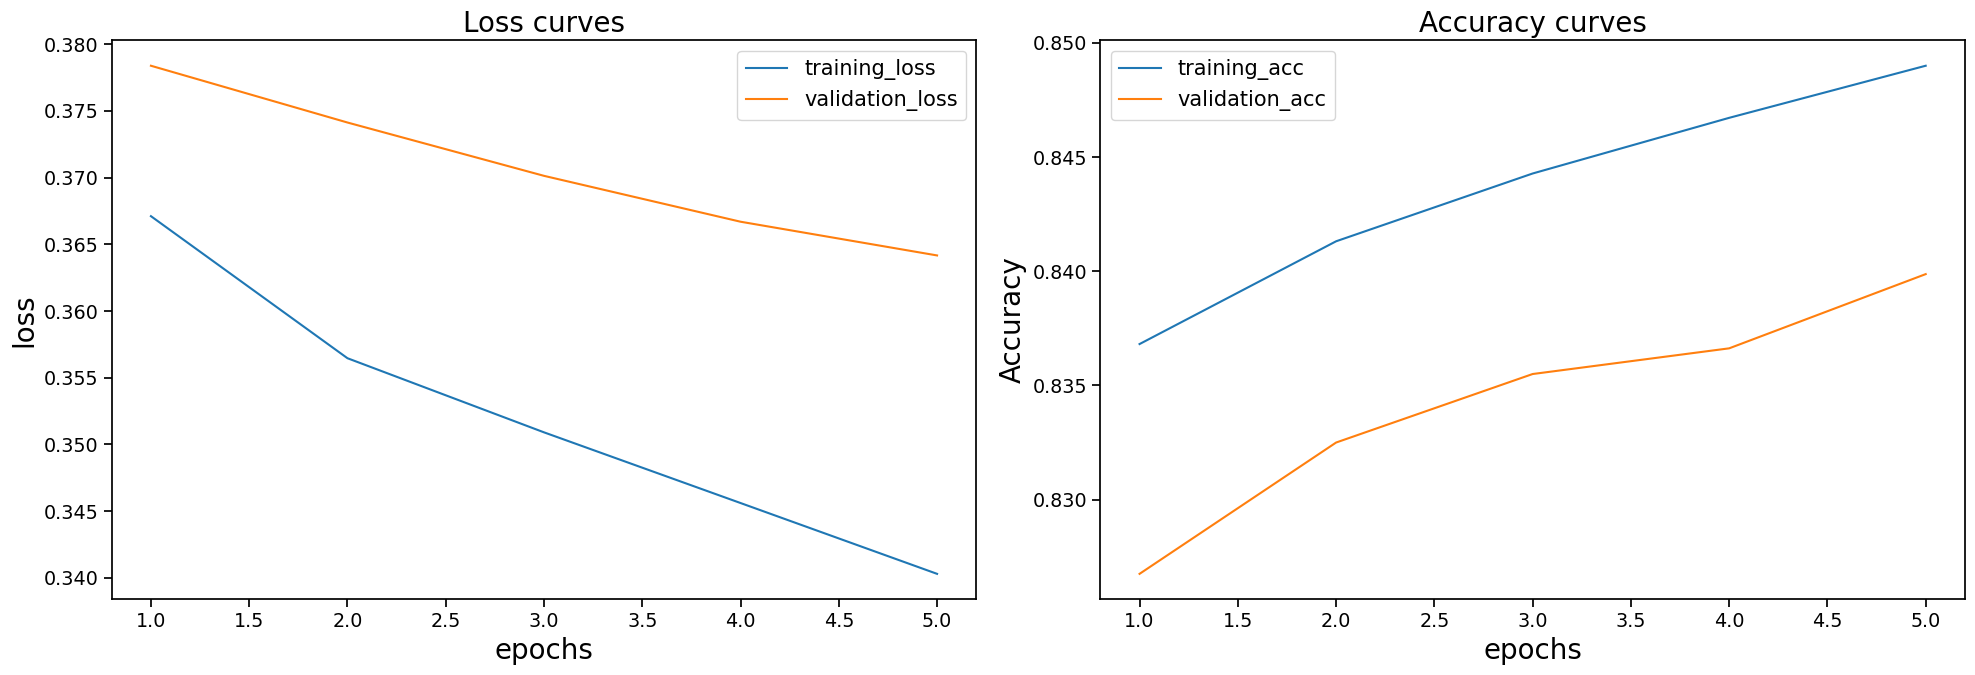

In [ ]:
plot_loss_curves(model_5_history)

###Fine Tuned


In [ ]:
pretained_embedding.trainable=True

In [ ]:
model_5.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [ ]:
early_stopping_cb=keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True,verbose=2)
reduce_lr_cb=keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=2,min_delta=0.001,min_lr=1e-7,verbose=2)

In [ ]:
model_5_history_fn=model_5.fit(
    training_dataset,
    epochs=25,
    steps_per_epoch=len(training_dataset),
    initial_epoch=4,
    validation_data=test_dataset,
    validation_steps=len(test_dataset),
    callbacks=[early_stopping_cb,reduce_lr_cb]
)

Epoch 5/25
  33/1000 [..............................] - ETA: 59:32 - loss: 0.3505 - accuracy: 0.8381

KeyboardInterrupt: ignored

In [ ]:
start_time=timeit.default_timer()
model_5_pred_prob_fn=model_5.predict(test_dataset)
model_5_pred_fn=tf.squeeze(tf.round(model_5_pred_prob_fn))
end_time=timeit.default_timer()
time_taken_per_instance=(end_time-start_time)/len(xtest)
model_5_results_fn=binary_clf_evaluation(ytest,model_5_pred_fn,time_taken_per_instance)
display_results(model_5_results_fn)